# Τεχνολογίες Κινητού Υπολογισμού με Μηχανική Μάθηση
### Ακ. Έτος 2024-2025
## 2η Εργαστηριακή Άσκηση: "Βελτιστοποίηση Νευρωνικών Δικτύων για Ανάπτυξη σε Συσκευές με Περιορισμένους Πόρους"

# Βιβλιοθήκες

Η βιβλιοθήκη `tensorflow_model_optimization` που χρειαζόμαστε για την κβαντοποίηση είναι η μόνη -από αυτές που θα χρειαστούμε- που δεν είναι προεγκατεστημένη στο Kaggle, οπότε την εγκαθιστούμε εμείς.

In [ ]:
!pip install tensorflow_model_optimization --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [55]:
import numpy as np # linear algebra
import pandas as pd # dataset
import tensorflow as tf # neural networks
import tensorflow_model_optimization as tfmot # neural networks optimization (quantization)
import matplotlib.pyplot as plt # plots

# scikit-learn for data preprocessing, metrics, etc.
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler  # Import UnderSampler

In [56]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

Για reproducability, ορίσαμε seed για το numpy και το tensorflow, έτσι ώστε να μπορούμε να αναπαράγουμε τα αποτελέσματα μας.

In [57]:
# For reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Συναρτήσεις

Παρακάτω σας δίνεται η συνάρτηση `plot_history(history)`. Δέχεται ως είσοδο το αντικείμενο History που επιστρέφει η μέθοδος `model.fit(...)` και δημιουργεί ένα διάγραμμα με τις καμπύλες εκπαίδευσης του μοντέλου.

In [61]:
def plot_history(history):

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    
    num_epochs = len(history.epoch)
    epochs = [x+1 for x in history.epoch]
    
    ax1.plot(epochs, history.history["loss"], marker='.', label="train_loss")
    ax1.plot(epochs, history.history["val_loss"], marker='.', label="val_loss")
    ax1.set_ylabel("Loss")
    ax1.set_title("Train and Validation Loss Over Epochs", fontsize=14)
    ax1.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax1.set_xlabel("Epochs")
    ax1.legend()
    ax1.grid()
    
    ax2.plot(epochs, history.history["accuracy"], marker='.', label="train_accuracy")
    ax2.plot(epochs, history.history["val_accuracy"], marker='.', label="val_accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Train and Validation Accuracy Over Epochs", fontsize=14)
    ax2.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax2.set_xlabel("Epochs")
    ax2.legend()
    ax2.grid()

    ax3.plot(epochs, history.history["f1_score"], marker='.', label="train_f1_score")
    ax3.plot(epochs, history.history["val_f1_score"], marker='.', label="val_f1_score")
    ax3.set_ylabel("F1-Score")
    ax3.set_title("Train and Validation F1-Score Over Epochs", fontsize=14)
    ax3.set_xticks(epochs[0::int(num_epochs/5)], epochs[0::int(num_epochs/5)])
    ax3.set_xlabel("Epochs")
    ax3.legend()
    ax3.grid()
    
    plt.show()
    
    return

# Σύνολο Δεδομένων

Στο πλαίσιο της εργαστηριακής άσκησης θα χρησιμοποιηθεί ένα υποσύνολο του συνόλου δεδομένων **[CICIoT2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html)**, το οποίο περιλαμβάνει 46 χαρακτηριστικά ροών κίνησης πακέτων IP σε ένα δίκτυο IoT με σκοπό την ανίχνευση εισβολών (intrusion detection).

Το αρχικό σύνολο δεδομένων περιέχει πάνω από 45 εκατομμύρια δείγματα σε 34 κλάσεις, με μια κλάση να αντιστοιχεί στην καλοήθη (benign) κίνηση και οι υπόλοιπες 33 να αφορούν διάφορες δικτυακές επιθέσεις. Οι 33 επιθέσεις μπορούν να ομαδοποιηθούν σε 7 κατηγορίες, ώστε τελικά να προκύψει ένα πρόβλημα ταξινόμησης 8 κλάσεων.

Ένα βασικό ζήτημα που αντιμετωπίζουν τα περισσότερα δικτυακά σύνολα δεδομένων είναι η ανισορροπία των κλάσεων (class imbalance), η οποία προκύπτει από την ετερογένεια της δικτυακής κίνησης, καθώς διαφορετικά είδη επιθέσεων παράγουν διαφορετικό όγκο πακέτων και ροών. Το αρχικό σύνολο δεδομένων, χωρισμένο στις 8 κατηγορίες, περιλαμβάνει το πλήθος δειγμάτων ανά κατηγορία που φαίνεται στην 3η στήλη του παρακάτω πίνακα. Το σύνολο δεδομένων που σας δίνεται είναι ένα υποσύνολο του αρχικού, ώστε τα δείγματα κάθε κατηγορίας να μην ξεπερνούν τα 150 χιλιάδες, οδηγώντας σε συνολικά περίπου 940 χιλιάδες δείγματα, γι' αυτό και ονομάζουμε το υποδειγματοληπτημένο σύνολο δεδομένων **CICIoT2023-1M**. Η ανισορροπία δεν είναι τόσο έντονη όσο στο αρχικό, ωστόσο συνεχίζει να υπάρχει σε έναν βαθμό.

|ΑΑ    |Κατηγορία                            |Αρχικό Πλήθος Δειγμάτων| Υποδειγματοληψία | 
|------|-------------------------------------|----------------|---------|
|1     |DDoS (Distributed Denial of Service) |33,984,560      | 150,000 |
|2     |DoS (Denial of Service)              |8,090,738       | 150,000 |
|3     |Mirai                                |2,634,124       | 150,000 |
|4     |Benign                               |1,098,195       | 150,000 |
|5     |Spoofing                             |486,504         | 150,000 |
|6     |Recon (Reconnaissance)               |354,565         | 150,000 |
|7     |Web                                  |24,829          | 24,829  |
|8     |BruteForce                           |13,064          | 13,064  |
|-     |ΣΥΝΟΛΟ                               |46,686,579      | 937,893 |

Κάθε δείγμα (γραμμή) στο σύνολο δεδομένων αφορά μια **ροή (flow)**. Μια ροή αντιπροσωπεύει μια ακολουθία πακέτων IP που μοιράζονται ένα σύνολο κοινών χαρακτηριστικών, που συνήθως ρέουν μεταξύ της ίδιας πηγής και προορισμού μέσα σε ένα συγκεκριμένο χρονικό πλαίσιο. Τυπικά ορίζεται από έναν συνδυασμό πεδίων στις επικεφαλίδες των πακέτων IP, που συχνά αποκαλούνται "5-πλειάδες" (5-tuples) στα δίκτυα IP:
1. Διεύθυνση IP πηγής: Προσδιορίζει τον αποστολέα του πακέτου.
2. Διεύθυνση IP προορισμού: Προσδιορίζει τον παραλήπτη του πακέτου.
3. Θύρα προέλευσης: Προσδιορίζει τον αριθμό θύρας στο μηχάνημα προέλευσης (για πρωτόκολλα όπως το TCP και το UDP).
4. Θύρα προορισμού: Προσδιορίζει τον αριθμό θύρας στο μηχάνημα προορισμού (για πρωτόκολλα όπως το TCP και το UDP).
5. Πρωτόκολλο: Υποδεικνύει το πρωτόκολλο του επιπέδου μεταφοράς (π.χ. TCP, UDP, ICMP).

Μια ροή μπορεί να περιλαμβάνει πρόσθετα πεδία αλλά η 5-πλειάδα είναι συνήθως επαρκής για τον μοναδικό προσδιορισμό μιας ροής.

## Σύνολο Δεδομένων Εκπαίδευσης

Το σύνολο που σας δίνεται για εκπαίδευση (train.csv) περιέχει το 90% των δειγμάτων, δηλαδή 844103 δείγματα. Οι 46 πρώτες στήλες του dataframe περιέχουν τα χαρακτηριστικά και η τελευταία περιέχει τις ετικέτες.

In [62]:
file = "/kaggle/input/mcml-24-25-lab-2-intrusion-detection-in-iot/train.csv"
df_train = pd.read_csv(file)

In [63]:
df_train.shape

(844103, 47)

In [64]:
df_train.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,3.206987,6801.30,7.00,64.40,272642.985162,272642.985162,0.0,0.0,0.0,0.0,...,115.385548,187.60,1.665194e+08,13.5,17.320894,163.550795,1.362632e+04,1.00,244.60,Benign
1,1.544619,3416618.90,6.00,185.80,927.412753,927.412753,0.0,0.0,0.0,0.0,...,1250.704543,2811.50,2.255917e-04,5.5,48.108444,1768.763327,2.268369e+06,0.90,38.50,Spoofing
2,131.762750,15188.25,7.56,67.70,203.062327,203.062327,0.0,0.0,0.0,0.0,...,75.119099,127.91,8.324383e+07,9.5,15.285089,106.358994,8.583812e+03,0.93,141.55,Recon
3,0.167141,30439.08,16.34,74.32,3528.975541,3528.975541,0.0,0.0,0.0,0.0,...,22.269627,92.00,8.301651e+07,9.5,10.497624,31.699151,1.228085e+04,0.06,141.55,DoS
4,0.000000,52.92,5.88,62.72,575.139958,575.139958,0.0,0.0,0.0,0.0,...,0.189317,54.12,8.294674e+07,9.5,10.397101,0.268643,2.796946e-01,0.13,141.55,DoS


In [65]:
df_train['label'].value_counts()

label
Mirai         135212
Benign        135087
Spoofing      135007
Recon         134920
DoS           134888
DDoS          134815
Web            22426
BruteForce     11748
Name: count, dtype: int64

## Σύνολο Δεδομένων Ελέγχου

Το σύνολο που σας δίνεται για έλεγχο (test.csv) περιέχει το υπόλοιπο 10% των δειγμάτων, δηλαδή 93790 δείγματα. Η πρώτη στήλη του dataframe περιέχει έναν ακέραιο αριθμό, που αποτελεί το αναγνωριστικό κάθε δείγματος και οι υπόλοιπες 46 περιέχουν τα χαρακτηριστικά. **Οι ετικέτες για το σύνολο ελέγχου δεν είναι διαθέσιμες.**

In [66]:
file = "/kaggle/input/mcml-24-25-lab-2-intrusion-detection-in-iot/test.csv"
x_test = pd.read_csv(file)

In [67]:
x_test.shape

(93790, 47)

In [68]:
x_test.head()

,id,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,771638,0.018130,71.8,6.0,153.3,31.720781,31.720781,0,0,0,...,56.953016,1.141231,55.6,3.076506e-03,5.5,10.672303,1.613945,2.182454,0.6,38.50
1,528847,0.513357,753493.8,6.0,123.0,976.700469,976.700469,0,0,0,...,66.000000,0.000000,66.0,2.233980e-04,5.5,11.489125,0.000000,0.000000,0.0,38.50
2,342335,0.119345,227223.1,17.0,64.0,3435.607239,3435.607239,0,0,0,...,554.000000,0.000000,554.0,8.378493e+07,9.5,33.286634,0.000000,0.000000,0.0,141.55
3,372124,0.000000,0.0,47.0,64.0,20.053136,20.053136,0,0,0,...,592.000000,0.000000,592.0,8.368115e+07,9.5,34.409301,0.000000,0.000000,0.0,141.55
4,328160,0.000000,0.0,47.0,64.0,72.516256,72.516256,0,0,0,...,592.000000,0.000000,592.0,8.367705e+07,9.5,34.409301,0.000000,0.000000,0.0,141.55


# Προεπεξεργασία Δεδομένων

Τα 46 χαρακτηριστικά του συνόλου δεδομένων φαίνονται παρακάτω. Για μια πιο λεπτομερή περιγραφή ρίξτε μια ματιά στο άρθρο:

Neto, Euclides Carlos Pinto, et al. "CICIoT2023: A real-time dataset and benchmark for large-scale attacks in IoT environment." *Sensors* 23.13 (2023): 5941.

[https://www.mdpi.com/1424-8220/23/13/5941](https://www.mdpi.com/1424-8220/23/13/5941)

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844103 entries, 0 to 844102
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    844103 non-null  float64
 1   Header_Length    844103 non-null  float64
 2   Protocol Type    844103 non-null  float64
 3   Duration         844103 non-null  float64
 4   Rate             844103 non-null  float64
 5   Srate            844103 non-null  float64
 6   Drate            844103 non-null  float64
 7   fin_flag_number  844103 non-null  float64
 8   syn_flag_number  844103 non-null  float64
 9   rst_flag_number  844103 non-null  float64
 10  psh_flag_number  844103 non-null  float64
 11  ack_flag_number  844103 non-null  float64
 12  ece_flag_number  844103 non-null  float64
 13  cwr_flag_number  844103 non-null  float64
 14  ack_count        844103 non-null  float64
 15  syn_count        844103 non-null  float64
 16  fin_count        844103 non-null  floa

### TODO: Προεπεξεργασία Δεδομένων

Όλα τα χαρακτηριστικά του συνόλου δεδομένων είναι αριθμητικά (τύπος float64), επομένως δεν χρειάζεται η διακριτοποίηση κάποιου κατηγορικού χαρακτηριστικού. Επίσης, δεν υπάρχουν ελλείπουσες τιμές.

Τα **απαραίτητα** βήματα προεπεξεργασίας που πρέπει να εφαρμοστούν είναι:
* Διαχωρισμός του συνόλου εκπαίδευσης στα υποσύνολα εκπαίδευσης (train) και επικύρωσης (val). Μπορείτε να δοκιμάσετε διάφορα ποσοστά διαχωρισμού.
* Κανονικοποίηση (normalization). Αν η μέθοδος κανονικοποίησης που θα εφαρμόσετε απαιτεί προσαρμογή στα δεδομένα, τότε αυτή η προσαρμογή πρέπει να γίνει ***μόνο** στο σύνολο εκπαίδευσης (μετά και τον διαχωρισμό του συνόλου επικύρωσης)*. Παράδειγμα αποτελεί η κανονικοποίηση z-score, όπου απαιτείται η εκμάθηση της μέσης τιμής και της τυπικής απόκλισης κάθε χαρακτηριστικού στο σύνολο εκπαίδευσης, προτού μετασχηματίσει τα δεδομένα. Δείτε [εδώ](https://scikit-learn.org/1.5/modules/preprocessing.html#).

Τα **προαιρετικά** βήματα προεπεξεργασίας που μπορούν να εφαρμοστούν είναι:
* Επαύξηση του συνόλου εκπαίδευσης για την αντιμετώπιση της ανισορροπίας των κλάσεων. Μπορείτε να χρησιμοποιήσετε τις βιβλιοθήκες [imblearn](https://imbalanced-learn.org/stable/user_guide.html) και [ctgan](https://github.com/sdv-dev/CTGAN).
* Μηχανική χαρακτηριστικών. Χρησιμοποιήστε αλγορίθμους όπως οι PCA, LDA, t-SNE για εξαγωγή χαρακτηριστικών και το module [sklearn.feature_selection](https://scikit-learn.org/1.5/modules/feature_selection.html) για επιλογή χαρακτηριστικών.

Αρχικά, ας ξεκινήσουμε με τον διαχωρισμό του συνόλου εκπαίδευσης σε train και validation split. Θα διαχωρίσουμε τα δεδομένα σε spli 85-15 και αυτό διότι έχουμε αρκετά δεδομένα και θέλουμε να έχουμε αρκετά δεδομένα για το validation set.

In [70]:
X = df_train.drop(columns=['label'])
y = df_train['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.15,
    random_state=SEED,
    stratify=y
)

Η επιλογή των features θα γίνει με τη χρήση του SelectKBest με τη χρήση της μετρικής mutual information για classification. 

To Mutual Information (MI) μετρά την αλληλεξάρτηση μεταξύ δύο μεταβλητών. Είναι μη-παραμετρικό και μπορεί να ανιχνεύσει κάθε είδους σχέση. Η MI μετρά την πληροφορία που μια μεταβλητή περιέχει για την άλλη. Αν η MI μεταξύ δύο μεταβλητών είναι μηδέν, τότε οι μεταβλητές είναι ανεξάρτητες. Αντίθετα, αν η MI είναι μεγάλη, τότε οι μεταβλητές είναι σχετικές. Η MI μπορεί να χρησιμοποιηθεί για την επιλογή χαρακτηριστικών, καθώς μπορεί να ανιχνεύσει κάθε είδους σχέση μεταξύ μεταβλητών.

Στην περίπτωση μας επιλέγουμε να κρατήσουμε 30 χαρακτηριστικά.

In [71]:
selector = SelectKBest(mutual_info_classif, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

In [72]:
# Get the boolean mask of selected features
mask = selector.get_support()

# Extract the names of the selected features
selected_features = X_train.columns[mask]
selected_features

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'syn_flag_number', 'ack_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTPS', 'TCP', 'UDP', 'ICMP',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight'],
      dtype='object')

Εφόσον, έχουμε επιλέξει τα χαρακτηριστικά μας, θα κρατήσουμε μόνο αυτά στα train και validation set.

In [73]:
# Convert the NumPy arrays back to pandas DataFrames with selected feature names
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_val_selected = pd.DataFrame(X_val_selected, columns=selected_features, index=X_val.index)

In [19]:
X_train_selected

,flow_duration,Header_Length,Protocol Type,Duration,syn_count,urg_count,rst_count,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
201179,0.000000,0.0,46.53,63.36,0.0,0.0,0.0,5980.94,489.94,578.0,568.860375,25.825320,572.82,8.364676e+07,9.5,33.722086,36.561724,4109.960800,0.17,141.55
520937,14.749583,1702924.1,17.00,120.20,0.0,0.0,0.0,14013.90,66.00,1237.0,899.583958,409.767505,900.30,1.666104e+08,13.5,42.392358,580.636966,169134.441171,1.00,244.60
235645,0.033285,29875.0,17.00,64.00,0.0,0.0,0.0,525.00,50.00,50.0,50.000000,0.000000,50.00,8.301647e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55
536498,7.529800,108.0,6.00,64.00,0.0,0.0,0.0,567.00,54.00,54.0,54.000000,0.000000,54.00,8.295117e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
218662,2.812266,6423.5,11.50,67.90,0.4,13.7,29.0,4836.10,50.00,3489.0,318.419360,850.618445,114.10,1.665229e+08,13.5,25.241278,1205.503101,731903.070511,1.00,244.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73395,1.165569,150407.4,6.00,89.50,1.2,5.8,141.5,1148.20,54.00,230.0,74.671823,48.219512,58.00,1.664299e+08,13.5,12.223248,68.334540,2349.573668,1.00,244.60
788789,1.347165,445131.0,17.00,60.00,0.0,0.0,0.0,20259.00,75.00,1392.0,1303.922806,327.271414,1392.00,1.665227e+08,13.5,51.059245,463.828480,108360.012438,1.00,244.60
335183,120.064149,105593.7,6.00,76.60,1.1,314.7,662.3,430.90,56.40,147.0,81.004722,32.714997,73.70,1.305192e-02,5.5,12.696784,46.265992,1225.251510,0.90,38.50
524718,16.193795,243266.3,10.30,62.50,0.0,0.0,0.0,1680.00,46.00,365.0,109.155460,111.230144,106.90,1.668614e+08,13.5,14.790428,157.586822,12462.255876,1.00,244.60


In [74]:
df_under = X_train_selected.copy()
df_under['label'] = y_train

### Correlation Matrix

Ας δούμε την πίνακα συσχέτισης των χαρακτηριστικών μας. Με αυτόν τον τρόπο μπορούμε να δούμε αν υπάρχουν χαρακτηριστικά που είναι πολύ συσχετισμένα μεταξύ τους και να αποφασίσουμε αν θα τα κρατήσουμε ή όχι.

Επίσης, μπορούμε να δούμε και ενδιαφέρουσες συσχετίσεις μεταξύ των χαρακτηριστικών.

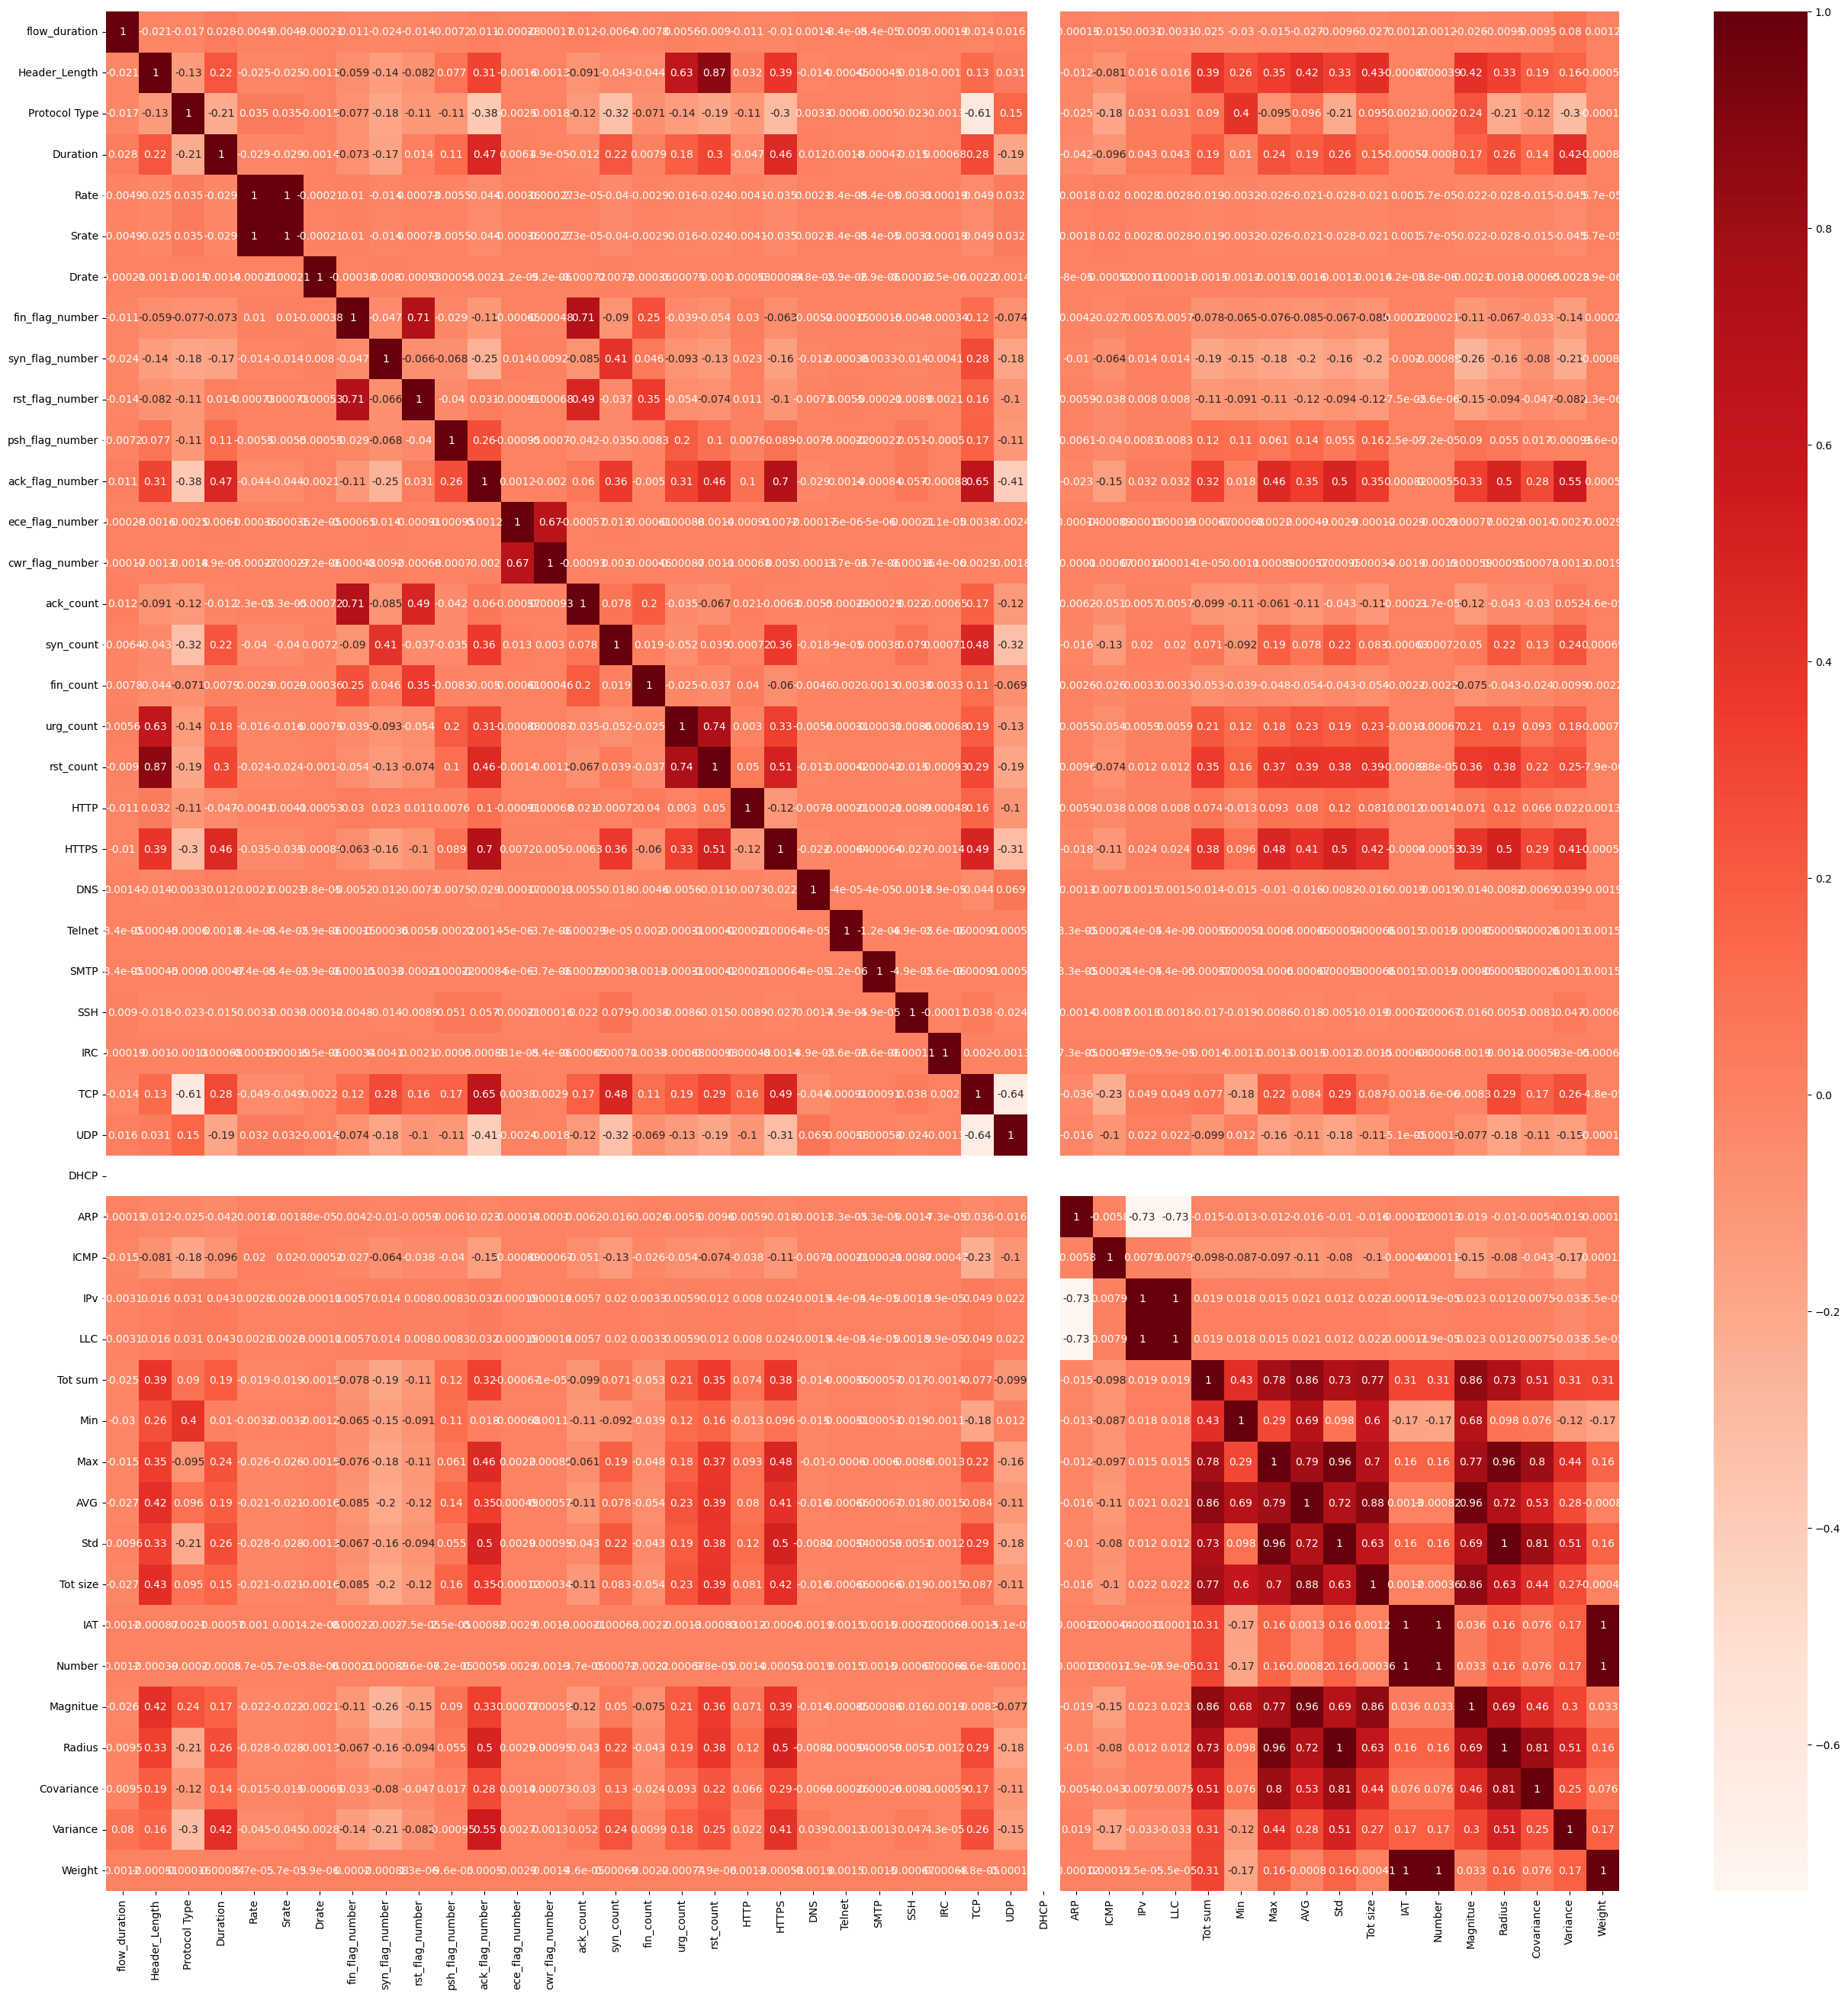

In [ ]:
import seaborn as sns
# Keep the non-categorical columns
df_numeric = df_train.select_dtypes(include=[np.number])
# Plot the correlation matrix
plt.figure(figsize=(32, 32))
cor = df_numeric.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Παρατηρούμε ότι πολλά χαρακτηρηστικά είναι πολύ συσχετισμένα μεταξύ τους. Αυτό μπορεί να οδηγήσει σε overfitting. Επομένως, θα πρέπει να επιλέξουμε τα χαρακτηριστικά μας με προσοχή
και να αφαιρέσουμε τα υπερβολικά συσχετισμένα χαρακτηριστικά. Συγκεκριμένα, μεταξύ αυτών θα αφαιρέσουμε εκείνο με το μικρότερο Chi squared score.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2

def remove_correlated_features(X, y, threshold=0.8):
    """
    Αφαιρεί ζεύγη χαρακτηριστικών που έχουν απόλυτη συσχέτιση πάνω από το όριο (threshold).
    Για το κάθε ζεύγος, διατηρεί το χαρακτηριστικό με το υψηλότερο στατιστικό (chi-square) σε σχέση με το label,
    και αφαιρεί το άλλο.

    Parameters:
    -----------
    X : pd.DataFrame
        DataFrame με τα αρχικά χαρακτηριστικά (μόνο τα features, χωρίς τη στήλη label).
    y : array
        Ο πίνακας με τις ετικέτες των κλάσεων.
    threshold : float
        Όριο συσχέτισης πάνω από το οποίο θα ελέγχονται τα ζεύγη χαρακτηριστικών και θα αφαιρείται το χειρότερο.

    Returns:
    --------
    X_filtered : pd.DataFrame
        DataFrame με τα επιλεγμένα χαρακτηριστικά.
    removed_features : dict
        Λεξικό με τα αφαιρεμένα χαρακτηριστικά και τη συσχέτισή τους (και το λόγο αφαίρεσης).
    """

    # 1. Calculate correlation matrix
    corr_matrix = X.corr().abs()

    # 2. Create an upper triangle to avoid duplicating comparisons
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 3. Compute chi-square scores for each feature with respect to y
    #    Note: chi2 requires non-negative features and categorical y. Adapt if needed.
    chi_scores, p_values = chi2(X, y)

    # Build a lookup dict: {feature_name: (chi2_score, p_value)}
    feature_chi_map = {}
    for idx, col in enumerate(X.columns):
        feature_chi_map[col] = (chi_scores[idx], p_values[idx])

    # 4. Identify pairs of features with correlation > threshold
    removed_features = {}
    to_drop = set()  # use a set to avoid duplicates

    for col in upper.columns:
        # Find features correlated above the threshold with col
        high_corr = upper[col][upper[col] > threshold]
        for row_feature in high_corr.index:  # row_feature is correlated with col
            # Skip if one of them is already removed
            if row_feature in to_drop or col in to_drop:
                continue

            # Compare chi-square stats: keep the one with the higher chi2_score
            chi_row, p_row = feature_chi_map[row_feature]
            chi_col, p_col = feature_chi_map[col]

            # Decide which feature to drop
            if chi_row < chi_col:
                # row_feature has worse (lower) chi2 -> remove row_feature
                removed_features[row_feature] = {
                    'correlated_with': col,
                    'correlation': high_corr[row_feature],
                    'chi2_row': chi_row,
                    'chi2_col': chi_col
                }
                to_drop.add(row_feature)
            else:
                # col has worse chi2 -> remove col
                removed_features[col] = {
                    'correlated_with': row_feature,
                    'correlation': high_corr[row_feature],
                    'chi2_row': chi_row,
                    'chi2_col': chi_col
                }
                to_drop.add(col)

    # 5. Drop the identified features
    X_filtered = X.drop(columns=list(to_drop))

    return X_filtered, removed_features

# Remove correlated features from training data
df_filtered, removed_features = remove_correlated_features(
    df_under.drop('label', axis=1), df_under['label'],
    threshold=0.8
)


In [76]:
df_filtered['label'] = df_under['label']
print("Removed features:", list(removed_features.keys()))
print("Remaining features after correlation filtering:", df_filtered.shape[1] - 1)

Removed features: ['Srate', 'rst_count', 'AVG', 'Std', 'Number', 'Magnitue', 'Radius', 'Max', 'Weight']
Remaining features after correlation filtering: 21


Βλέπουμε ότι αφαιρέθηκαν τα χαρακτηριστικά : 'Srate', 'rst_count', 'AVG', 'Std', 'Number', 'Magnitue', 'Radius', 'Max', 'Weight', τα οποία είναι πολύ συσχετισμένα μεταξύ τους.

In [77]:
df_filtered['label'].value_counts()

label
Mirai         114930
Benign        114824
Spoofing      114756
Recon         114682
DoS           114655
DDoS          114592
Web            19062
BruteForce      9986
Name: count, dtype: int64

Παρατηρούμε ότι το dataset μας είναι πολύ imbalanced, όπου οι κλάσεις Web και BruteForce έχουν πολύ λίγα δείγματα. Επομένως, θα χρησιμοποιήσουμε την τεχνική του UnderSampling για να εξισορροπήσουμε το dataset μας,
σε ένα βαθμό που να μην αφαιρέσουμε πολλά δείγματα από τις υπόλοιπες κλάσεις.

In [78]:
max_samples = 60000  # Adjust based on resource constraints

# Instantiate the UnderSampler
under_sampler = RandomUnderSampler(
    sampling_strategy={
        'Benign': max_samples,
        'DDoS': max_samples,
        'DoS': max_samples,
        'Mirai': max_samples,
        'Recon': max_samples,
        'Spoofing': max_samples,
        # 'Web' and 'BruteForce' are minority classes, leave them untouched
    },
    random_state=SEED
)

# Separate features and labels
X_under = df_filtered.drop(columns=['label'])
y_under = df_filtered['label']

# Apply undersampling
X_under_res, y_under_res = under_sampler.fit_resample(X_under, y_under)

# Combine undersampled data into a DataFrame
df_under = X_under_res.copy()
df_under['label'] = y_under_res

print("\nClass distribution after undersampling:")
print(df_under['label'].value_counts())


Class distribution after undersampling:
label
Benign        60000
DDoS          60000
DoS           60000
Mirai         60000
Spoofing      60000
Recon         60000
Web           19062
BruteForce     9986
Name: count, dtype: int64


In [79]:
df_augmented = df_under.copy()

In [80]:
df_augmented

,flow_duration,Header_Length,Protocol Type,Duration,Rate,syn_flag_number,ack_flag_number,ack_count,syn_count,fin_count,...,TCP,UDP,ICMP,Tot sum,Min,Tot size,IAT,Covariance,Variance,label
309528,7.428168,83594.1,6.0,130.8,55.055129,0.0,1.0,0.0,1.8,0.0,...,1.0,0.0,0.0,3847.3,66.0,862.5,1.665254e+08,1.568571e+05,0.7,Benign
485994,50.481282,3705863.4,5.4,207.9,66.063369,0.0,1.0,0.0,1.8,0.0,...,1.0,0.0,0.0,27728.0,60.0,65.4,1.665212e+08,3.264194e+06,1.0,Benign
271253,53.621866,2300466.8,8.7,57.6,55.306255,0.0,1.0,0.0,1.2,0.0,...,1.0,0.0,0.0,21397.0,55.8,1700.7,1.665241e+08,2.341415e+06,1.0,Benign
297287,28.820639,1030742.0,7.1,120.5,82.284215,0.0,1.0,0.0,1.6,0.0,...,1.0,0.0,0.0,6432.2,348.0,1221.6,3.716278e-03,1.009654e+06,0.8,Benign
27185,47.254288,2356788.9,4.8,50.7,53.618672,0.0,1.0,0.0,1.2,0.0,...,1.0,0.0,0.0,6284.5,70.2,1715.1,9.010506e-03,1.873837e+06,0.9,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36301,9.053557,958.8,9.2,74.8,14.890558,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,629.8,68.4,132.8,2.539010e-02,4.005835e+03,0.9,Web
837851,16.877377,5347.4,9.9,130.3,11.112003,0.0,0.0,0.0,0.6,0.0,...,0.0,0.0,0.0,663.9,78.0,126.1,5.178471e-02,5.059008e+03,0.9,Web
773049,165.160408,7518.9,10.4,154.8,32.132704,0.0,1.0,0.5,0.8,0.0,...,1.0,0.0,0.0,479.3,60.0,87.8,4.310882e-02,1.370356e+03,0.6,Web
683261,623.726814,86935.3,5.5,70.4,0.214131,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1953.8,69.7,684.1,1.630549e-02,5.685016e+05,0.9,Web


Αφού τελειώσαμε το UnderSampling, θα συνεχίσουμε με το OneHotEncoding των ετικετών μας και τη κανονικοποίηση των δεδομένων μας με τη χρήση του QuantileTransformer.

In [81]:
X_train_final = df_augmented.drop(columns=['label'])
y_train_final = df_augmented['label']

In [82]:
# One-Hot Encode the labels
category_order = ['Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web']
encoder = OneHotEncoder(categories=[category_order], sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train_final.to_numpy().reshape(-1, 1))
y_val_encoded   = encoder.transform(y_val.to_numpy().reshape(-1, 1))

In [83]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal')
X_train_fs = scaler.fit_transform(X_train_final)
X_val_fs = X_val_selected[X_train_final.columns]
X_val_fs = scaler.transform(X_val_fs)

# TODO: Κατασκευή Μοντέλου

Σχετικά με το μοντέλο που θα κατασκευάσετε για την επίλυση του προβλήματος της ανίχνευσης εισβολών, υπάρχουν οι εξής περιορισμοί:
* Τα επίπεδα του μοντέλου θα πρέπει να επεξεργάζονται την είσοδο σειριακά (sequentially). Επομένως, δεν μπορούν να υπάρχουν παράλληλοι κλάδοι (branches) μέσα στο δίκτυο.
* Δεν μπορούν να χρησιμοποιηθούν όλα τα επίπεδα που είναι διαθέσιμα στο module [tf.keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) λόγω των περιορισμών της κβαντοποίησης. Φροντίστε ότι παρακάτω θα μπορεί να εφαρμοστεί στο μοντέλο επίγνωση κβαντοποίησης.

Επιπλέον, δεν υπάρχει περιορισμός ως προς τις τιμές των υπερπαραμέτρων εκπαίδευσης. Μπορείτε να δοκιμάσετε διάφορα μεγέθη δέσμης, διάφορους βελτιστοποιητές, καθώς και διάφορες τιμές για τις υπερπαραμέτρους αυτών (π.χ. ρυθμός μάθησης).

Κατασκευάστε το μοντέλο σας και εκπαιδεύστε το.

Δοκιμάσαμε πολλές αρχιτεκτονικές μοντέλων, αλλά το καλύτερο αποτέλεσμα που πήραμε ήταν με το μοντέλο που παρατίθεται παρακάτω, δίοτι μείωνε τον αριθμό των χρησιμοποιούμενων μεταβλητών
χωρίς να χάνει σημαντικά στην απόδοση του μοντέλου ως προς το accuracy και το f1-score.

In [141]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train_fs.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

Με τη μέθοδο ``summary`` μπορούμε να δούμε την αρχιτεκτονική του μοντέλου, δηλαδή τα επίπεδά του, το σχήμα εξόδου και το πλήθος των παραμέτρων τους. Η πρώτη διάσταση των εξόδων αντιστοιχεί στο batch size (μέγεθος δέσμης) και η τιμή None υποδηλώνει ότι το μοντέλο μπορεί να δεχτεί μεταβλητό batch size, δηλαδή οποιοδήποτε πλήθος εικόνων εισόδου ταυτόχρονα.

Με βάση την εκφώνηση, ο συνολικός αριθμός των παραμέτρων του μοντέλου (Total params) δεν θα πρέπει να ξεπερνά τις 10.000.

In [142]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                704       
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 16)                272       
                                                                 
 dense_34 (Dense)            (None, 8)                 136       
                                                                 
Total params: 2696 (10.53 KB)
Trainable params: 2696 (10.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Βλέπουμε ότι το μοντέλο μας έχει 2696 παραμέτρους, άρα είναι εντός των ορίων.

Για να εκπαιδεύσουμε ένα μοντέλο πρέπει να ορίσουμε τον βελτιστοποιητή (δηλαδή τον αλγόριθμο καθόδου κλίσης), τη συνάρτηση απώλειας και τη μετρική (ή τις μετρικές) αξιολόγησης, τα οποία ορίζονται με τη μέθοδο `compile`.

In [143]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')]
)

Για να αποφύγουμε την υπερπροσαρμογή (overfitting) αλλά και για να γνωρίζουμε πότε πρέπει να σταματήσει η εκπαίδευση, εφαρμόζουμε την τεχνική του πρόορου τερματισμού (early stopping). Με αυτό τον τρόπο, παρακολουθούμε (``monitor``) το σφάλμα επικύρωσης (val_loss) σε κάθε εποχή κι αν αυτό δεν μειωθεί περαιτέρω για έναν αριθμό από εποχές (``patience``), τότε η εκπαίδευση σταματά (καθώς αυτό αποτελεί σημάδι υπερπροσαρμογής). Όταν ο πρόορος τερματισμός ενεργοποιηθεί, η εκπαίδευση θα σταματήσει και στο μοντέλο θα φορτωθούν τα βάρη της καλύτερης εποχής, δηλαδή της εποχής με το χαμηλότερο σφάλμα επικύρωσης (``restore_best_weights=True``).

In [144]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

Η εκπαίδευση ξεκινά με τη μέθοδο ``fit``, στην οποία δίνουμε τα training και validation sets, ορίζουμε το μέγεθος δέσμης και μια σχετικά μεγάλη τιμή για τον μέγιστο αριθμό εποχών (π.χ. 200), καθώς θέλουμε η εκπαίδευση να σταματήσει λόγω του early stopping. Κατά τη διάρκεια της εκπαίδευσης μπορούμε να δούμε στο τέλος κάθε εποχής την απώλεια του μοντέλου και τις μετρικές αξιολόγησης για κάθε υποσύνολο.

In [145]:
history = model.fit(
    X_train_fs,
    y_train_encoded,
    epochs=200,
    validation_data=(X_val_fs, y_val_encoded),
    batch_size=256,
    callbacks=[early_stopping]
)


Epoch 1/200
1520/1520 [==============================] - 9s 4ms/step - loss: 0.4750 - accuracy: 0.8173 - f1_score: 0.7283 - val_loss: 0.2849 - val_accuracy: 0.8902 - val_f1_score: 0.8008
Epoch 2/200
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2947 - accuracy: 0.8836 - f1_score: 0.8230 - val_loss: 0.2598 - val_accuracy: 0.8995 - val_f1_score: 0.8238
Epoch 3/200
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2766 - accuracy: 0.8901 - f1_score: 0.8359 - val_loss: 0.2487 - val_accuracy: 0.8991 - val_f1_score: 0.8162
Epoch 4/200
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2677 - accuracy: 0.8936 - f1_score: 0.8411 - val_loss: 0.2272 - val_accuracy: 0.9104 - val_f1_score: 0.8409
Epoch 5/200
1520/1520 [==============================] - 6s 4ms/step - loss: 0.2614 - accuracy: 0.8958 - f1_score: 0.8452 - val_loss: 0.2326 - val_accuracy: 0.9075 - val_f1_score: 0.8405
Epoch 6/200
1520/1520 [==============================] - 6s 4ms/s

Αφού τελειώσει η εκπαίδευση, από το history του μοντέλου μπορούν να σχεδιαστούν οι καμπύλες εκπαίδευσης χρησιμοποιώντας τη συνάρτηση `plot_history` που σας έχει δοθεί.

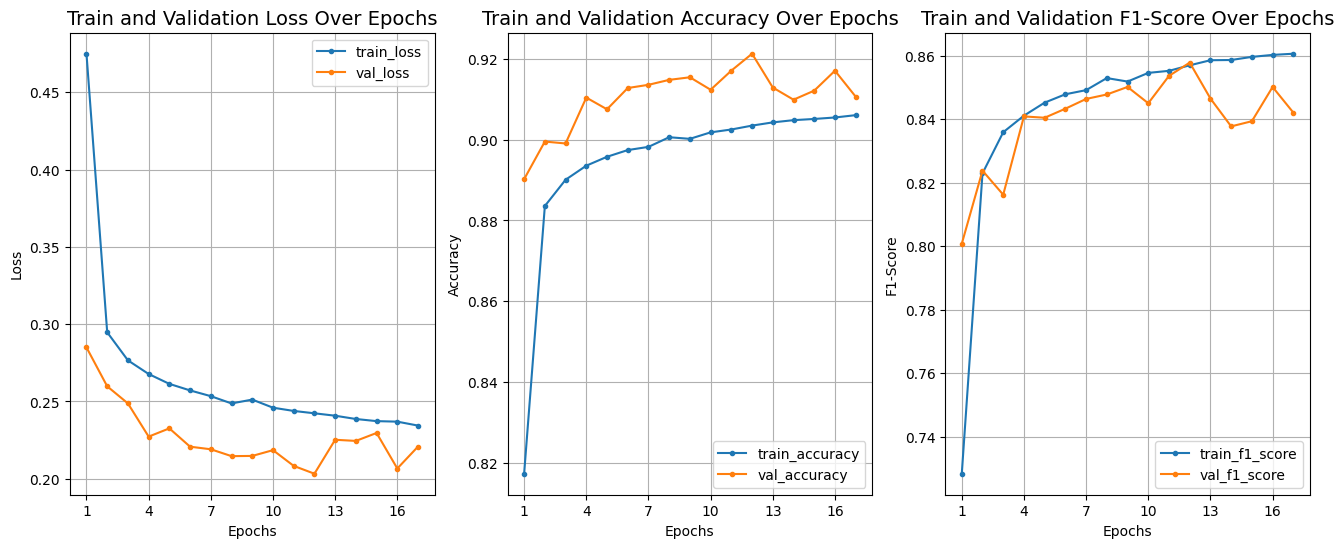

In [146]:
plot_history(history)

### Γράφημα Απώλειας (Loss)

Το πρώτο γράφημα δείχνει πώς η συνάρτηση απώλειας μειώνεται με την πάροδο των εποχών. Παρατηρούμε ότι:

- Η απώλεια εκπαίδευσης (μπλε γραμμή) ξεκινά από περίπου 0.47 και μειώνεται σταδιακά
- Η απώλεια επικύρωσης (πορτοκαλί γραμμή) ακολουθεί παρόμοια τάση, αλλά είναι χαμηλότερη
- Και οι δύο γραμμές σταθεροποιούνται μετά την εποχή 10, υποδεικνύοντας σύγκλιση

### Γράφημα Ακρίβειας (Accuracy)

Στο δεύτερο γράφημα βλέπουμε την εξέλιξη της ακρίβειας:

- Η ακρίβεια εκπαίδευσης αυξάνεται σταθερά από 82% σε περίπου 90%
- Η ακρίβεια επικύρωσης φτάνει σε υψηλότερα επίπεδα, περίπου 92%
- Παρατηρούμε μικρές διακυμάνσεις στην ακρίβεια επικύρωσης, το οποίο είναι φυσιολογικό

### Γράφημα F1-Score

Το τρίτο γράφημα απεικονίζει το F1-Score:

- Το F1-Score εκπαίδευσης και επικύρωσης ακολουθούν παρόμοια πορεία
- Και οι δύο μετρικές σταθεροποιούνται γύρω στο 0.84-0.86
- Παρατηρούνται κάποιες διακυμάνσεις στο F1-Score επικύρωσης μετά την εποχή 10

### Συνολική Αξιολόγηση

Το μοντέλο φαίνεται να εκπαιδεύεται αποτελεσματικά καθώς:

1. Δεν παρατηρείται σημαντική υπερπροσαρμογή (overfitting), αφού οι μετρικές επικύρωσης παραμένουν κοντά ή καλύτερες από τις μετρικές εκπαίδευσης

2. Η σύγκλιση επιτυγχάνεται σχετικά νωρίς (γύρω στην εποχή 10)

3. Οι τελικές επιδόσεις είναι ικανοποιητικές με:
   - Ακρίβεια επικύρωσης ~91%
   - F1-Score ~0.84
   - Σταθερή μείωση της απώλειας

# Μοντέλο με Επίγνωση Κβαντοποίησης

Το επόμενο βήμα είναι να εφαρμόσουμε κβαντοποίηση στο εκπαιδευμένο μοντέλο. Με την επίγνωση κβαντοποίησης, το μοντέλο δεν κβαντοποιείται στην πραγματικότητα (οι παράμετροι του παραμένουν στη μορφή float32), αλλά του δίνεται η δυνατότητα να **μιμείται** την κβαντοποίηση κατά τη διάρκεια της εκπαίδευσης, ώστε οι παράμετροι του να βελτιστοποιηθούν με βάση το σφάλμα που προκύπτει από την κβαντισμένη εμπρόσθια διάδοση (και όχι την εμπρόσθια διάδοση με float32 αριθμούς).

Για την εφαρμογή επίγνωσης κβαντοποίησης στο μοντέλο μας χρησιμοποιούμε τη συνάρτηση `quantize_model(model)`, με την οποία εφαρμόζουμε την προκαθορισμένη μέθοδο κβαντοποίησης, την int8. Όπως αναφέρθηκε και παραπάνω, θα πρέπει στα επίπεδα του μοντέλου σας να μπορεί να εφαρμοστεί επίγνωση κβαντοποίησης, οπότε φροντίστε το παρακάτω κελί να εκτελεστεί χωρίς σφάλματα.

In [40]:
print(type(model))

<class 'tf_keras.src.engine.sequential.Sequential'>


In [159]:
quant_aware_model = tfmot.quantization.keras.quantize_model(model)
quant_aware_model.summary(line_length=120)

Model: "sequential_6"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 quantize_layer_13 (QuantizeLayer)                    (None, 21)                                      3                 
                                                                                                                        
 quant_dense_30 (QuantizeWrapperV2)                   (None, 32)                                      709               
                                                                                                                        
 quant_dense_31 (QuantizeWrapperV2)                   (None, 32)                                      1061              
                                                                                                                        
 quant_den

Στο μοντέλο με επίγνωση κβαντοποίησης έχουν προστεθεί κάποιες non-trainable παράμετροι. Εν γένει, οι non-trainable παράμετροι μπορεί να είναι δύο ειδών:
1. Παράμετροι οι οποίες δεν μεταβάλλονται καθόλου κατά την εκπαίδευση.
2. Παράμετροι οι οποίες μεταβάλλονται αλλά λειτουργούν σαν στατιστικές τιμές και δεν "μαθαίνονται" κατά την εκπαίδευση, αλλά ανανεώνονται με ελάχιστες, μέγιστες, μέσες τιμές, διακυμάνσεις, κ.α.

### TODO: Επεξήγηση Μη Εκπαιδεύσιμων Παραμέτρων

Βρείτε και εξηγήστε ποιος είναι ο λόγος ύπαρξης των μη εκπαιδεύσιμων παραμέτρων κατά την εφαρμογή της επίγνωσης κβαντοποίησης. Αναλύστε το πλήθος και τη λειτουργία τους.

Η επίγνωση κβαντοποίησης (Quantization Aware Training - QAT) είναι μια τεχνική που εφαρμόζεται κατά την εκπαίδευση νευρωνικών δικτύων για να μειώσει το μέγεθος του μοντέλου και να αυξήσει την αποδοτικότητα του, διατηρώντας ταυτόχρονα την ακρίβεια. Σε αυτό το πλαίσιο, οι μη εκπαιδεύσιμες παράμετροι διαδραματίζουν κρίσιμο ρόλο.

#### Λόγοι Ύπαρξης Μη Εκπαιδεύσιμων Παραμέτρων

1. **Διατήρηση Σταθερότητας της Κβαντοποίησης**: Οι μη εκπαιδεύσιμες παράμετροι, όπως οι παράμετροι κλιμάκωσης (scaling factors) και τα μηδενικά σημεία (zero points), χρησιμοποιούνται για να μετατρέπουν τις πραγματικές τιμές σε κβαντοποιημένες τιμές. Αυτές οι παράμετροι πρέπει να παραμένουν σταθερές κατά την εκπαίδευση για να διατηρηθεί η συνέπεια της κβαντοποίησης.

2. **Βελτιστοποίηση Υπολογιστικής Αποδοτικότητας**: Με τη μη εκπαίδευση ορισμένων παραμέτρων, μειώνεται ο αριθμός των βαρών που απαιτείται να ενημερωθούν μέσω backpropagation, αυξάνοντας έτσι την αποδοτικότητα της εκπαίδευσης.

3. **Αποφυγή Υπερπροσαρμογής**: Οι μη εκπαιδεύσιμες παράμετροι βοηθούν στο να αποφεύγεται η υπερπροσαρμογή του μοντέλου στα δεδομένα εκπαίδευσης, διατηρώντας παράλληλα τη γενίκευση του μοντέλου.

#### Πλήθος Μη Εκπαιδεύσιμων Παραμέτρων

Το πλήθος των μη εκπαιδεύσιμων παραμέτρων εξαρτάται από τη δομή του δικτύου και τον τρόπο κβαντοποίησης που εφαρμόζεται. Συνήθως, για κάθε στρώση που υποβάλλεται σε κβαντοποίηση, υπάρχουν τουλάχιστον δύο μη εκπαιδεύσιμες παράμετροι:

1. **Scale (Κλίμακα)**: Καθορίζει τη μετατροπή των πραγματικών τιμών σε κβαντοποιημένες.
2. **Zero Point (Μηδενικό Σημείο)**: Καθορίζει το σημείο αναφοράς για την κβαντοποίηση.

Για παράδειγμα, σε ένα δίκτυο με N στρώσεις που υποβάλλονται σε κβαντοποίηση, το συνολικό πλήθος των μη εκπαιδεύσιμων παραμέτρων θα είναι περίπου 2N.

#### Λειτουργία Μη Εκπαιδεύσιμων Παραμέτρων

1. **Scale (Κλίμακα)**:
   - **Λειτουργία**: Μετατρέπει τις πραγματικές τιμές των βαρών και των ενεργοποιήσεων σε κβαντοποιημένες τιμές.
   - **Παράδειγμα**: Αν η κλίμακα είναι 0.1, τότε μια πραγματική τιμή 1.5 θα κβαντοποιηθεί ως 15 (με βάση αυτή την κλίμακα).

2. **Zero Point (Μηδενικό Σημείο)**:
   - **Λειτουργία**: Καθορίζει το σημείο αναφοράς για την κβαντοποίηση, επιτρέποντας την αναπαράσταση τόσο θετικών όσο και αρνητικών τιμών.
   - **Παράδειγμα**: Ένα μηδενικό σημείο στο 128 για 8-bit κβαντοποίηση σημαίνει ότι η πραγματική τιμή 0 αντιστοιχεί στην κβαντοποιημένη τιμή 128.

#### Συμπέρασμα

Οι μη εκπαιδεύσιμες παράμετροι στην επίγνωση κβαντοποίησης είναι απαραίτητες για την αποτελεσματική μετατροπή των πραγματικών τιμών σε κβαντοποιημένες, διατηρώντας ταυτόχρονα την ακρίβεια και την αποδοτικότητα του μοντέλου. Το πλήθος τους εξαρτάται από τη δομή του δικτύου, ενώ η λειτουργία τους είναι κρίσιμη για τη διατήρηση της σταθερότητας και της αποδοτικότητας κατά την εκπαίδευση και την υλοποίηση του κβαντοποιημένου μοντέλου.


### TODO: Εκπαίδευση Μοντέλου με Επίγνωση Κβαντοποίησης

Εκτελέστε έναν ακόμη γύρο εκπαίδευσης για το εκπαιδευμένο μοντέλο με επίγνωση κβαντοποίησης και σχεδιάστε τις καμπύλες εκπαίδευσης.

Εφόσον έχουμε ήδη εκπαιδεύσει το μοντέλο με την κβαντοποίηση, δεν χρειάζεται να κάνουμε εκ νέου την εκπαίδευση. Αντίθετα, μπορούμε να συνεχίσουμε από το σημείο που σταμάτησε η εκπαίδευση του μοντέλου με την επίγνωση κβαντοποίησης, αλλά αυτή τη φορά με μικρότερο learning rate.

In [160]:
quant_aware_model.compile( 
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')]
)

In [161]:
history = quant_aware_model.fit(
    X_train_fs,
    y_train_encoded,
    epochs=1,
    validation_data=(X_val_fs, y_val_encoded),
    batch_size=256,
    callbacks=[early_stopping],
)

1520/1520 [==============================] - 14s 7ms/step - loss: 0.3035 - accuracy: 0.8944 - f1_score: 0.8248 - val_loss: 0.1997 - val_accuracy: 0.9217 - val_f1_score: 0.8530


Με βάση την εκφώνηση, η ελάχιστη ανεκτή ακρίβεια (top-1 accuracy) για το κβαντισμένο μοντέλο είναι 90%. Εφόσον δεν υπάρχει η δυνατότητα ελέγχου της ακρίβειας στο σύνολο ελέγχου, μπορείτε να βασιστείτε στο σύνολο επικύρωσης.

Παρατηρούμε ότι το μοντέλο μας έχει πολύ καλή απόδοση, μόλις με εκπαίδευση μιας εποχής! 

Η ακρίβεια επικύρωσης είναι περίπου 92%, που υπερβαίνει το κατώφλι του 90% που ζητείται. Επιπλέον, το μοντέλο φαίνεται να συγκλίνει γρήγορα, με την απώλεια να μειώνεται σημαντικά από την πρώτη εποχή, με valiadtion f1-score 0.853.

# Προβλέψεις στο Σύνολο Ελέγχου - Kaggle Competition

Με τον παρακάτω κώδικα παράγονται οι προβλέψεις του κβαντισμένου μοντέλου για το σύνολο ελέγχου και κατασκευάζεται το csv αρχείο προς υποβολή στο kaggle.

Η πρώτη στήλη του αρχείου προς υποβολή περιέχει το ID του δείγματος, η δεύτερη το πλήθος των παραμέτρων του μοντέλου και οι υπόλοιπες 8 τις πεποιθήσεις του μοντέλου για κάθε κλάση.

Για να πραγματοποίησουμε τις προβλέψεις με το quantized μοντέλο, πρέπει να κρατήσουμε μόνο τα features με τα οποία εκπαιδεύτηκε το μοντέλο. 
Επίσης, πρέπει να πραγματοποιήσουμε και scaling των features, όπως κάναμε και κατά την εκπαίδευση, με τον ίδιο μετασχηματιστή.

In [162]:
model_params = model.count_params()

x_test_ = x_test.drop(columns=['id'])
x_test_ = x_test_[X_train_final.columns]

In [163]:
x_test_scaled = scaler.transform(x_test_)

pred = quant_aware_model.predict(x_test_scaled, verbose=0)

In [164]:
df_pred = pd.DataFrame(columns=['id', 'params', 'Benign', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Web'])

for id, prediction in zip(x_test['id'], pred):
    new_row = [id] + [model_params] + prediction.tolist()
    df_pred.loc[len(df_pred)] = new_row
    print(f"{len(df_pred)}/{len(x_test)}", end='\r')

df_pred['id'] = df_pred['id'].astype(int)
df_pred['params'] = df_pred['params'].astype(int)

In [165]:
df_pred.to_csv("predictions.csv", index=False)

# Αποθήκευση Μοντέλου

Το κβαντισμένο μοντέλο μπορεί να αποθηκευτεί στη μορφή TFLite, μια ελαφριά έκδοση του TensorFlow που έχει σχεδιαστεί για την ανάπτυξη μοντέλων σε κινητές συσκευές, ενσωματωμένα συστήματα και άλλα περιβάλλοντα με περιορισμούς πόρων. Μπορείτε να ανεβάσετε το αρχείο tflite στο [Netron](https://netron.app/) για μια οπτική αναπαράσταση της αρχιτεκτονικής του δικτύου.

In [166]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open('model_int.tflite', 'wb') as f:
  f.write(tflite_model)

/opt/conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1737215206.003524      23 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1737215206.003566      23 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.


Παρακάτω μπορούμε να δούμε την αρχιτεκτονική του μοντέλου μας, όπως παρουσιάστηκε στο Netron.

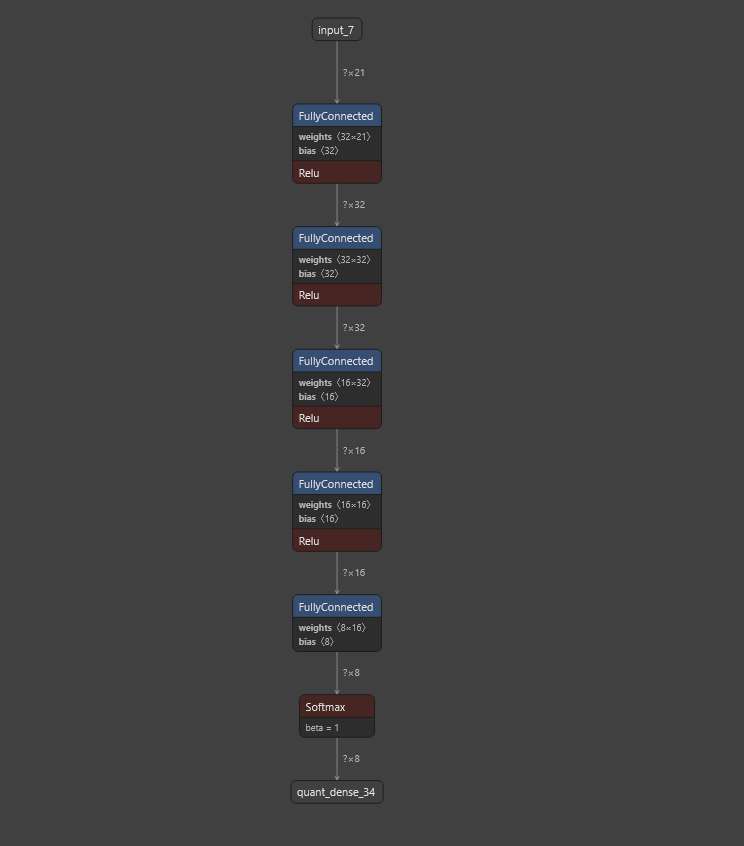

Το συγκεκριμένο μοντέλο, δίνει στον διαγωνισμό του Kaggle score = 0.84394.

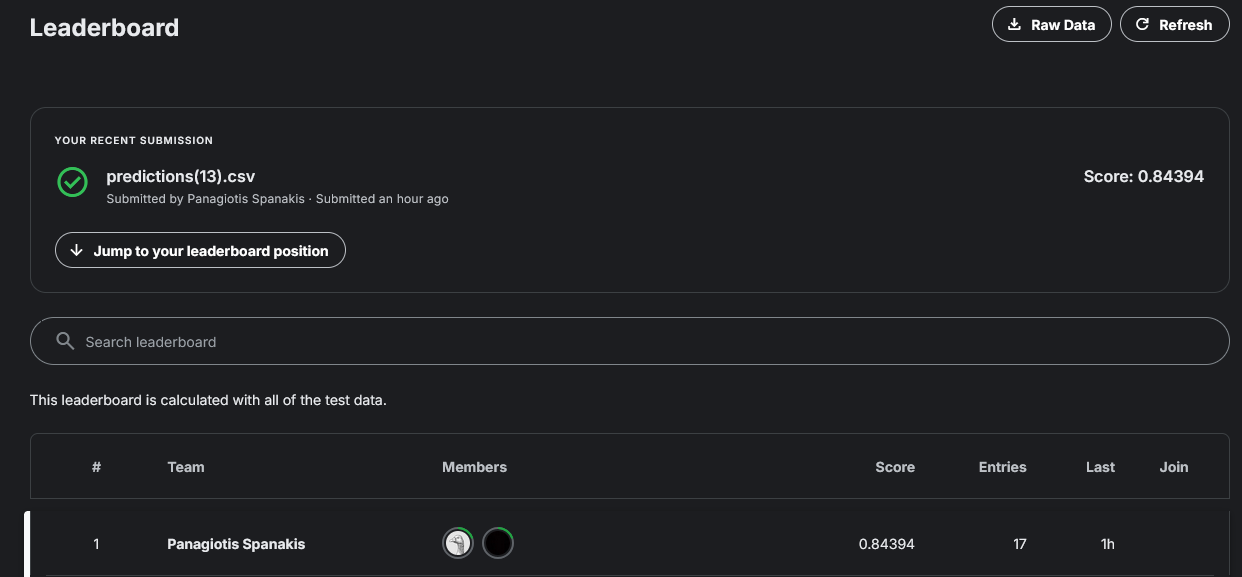

### Σημαντική Παρατήρηση 

Εκπαιδεύσαμε και ένα μοντέλο με ακόμα λιγότερες παραμέτρους, συγκεκριμένα μόνο 1304 παραμέτρους!

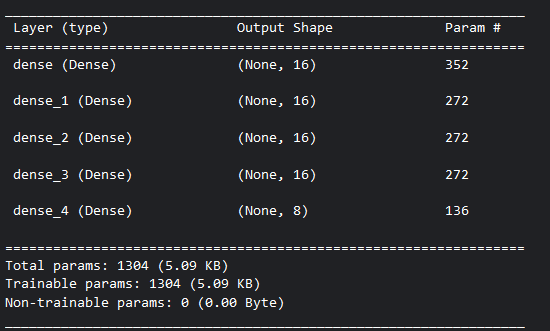

Αυτό το μοντέλο πέτυχε val_accuracy: 0.9143 - val_f1_score: 0.8491 στο αρχικό training με παρόμοια συμπεριφορά των training και validation graphs.

Επίσης, πέτυχε val_accuracy: 0.9142 - val_f1_score: 0.8439 στo QAT training, τα οποία είναι χαμηλότερα σε σχέση με το μοντέλο που παρουσιάστηκε παραπάνω.

Παρατηρούμε, όμως το μοντέλο με τις λιγότερες παραμέτρους έχει καλύτερη απόδοση στο Kaggle competition, με score = 0.85588. 

Αυτό μας δείχνει ότι το πλήθος των παραμέτρων έχει μεγάλο βάρος στο Kaggle competition, αλλά όχι απαραίτητα στην απόδοση του μοντέλου.

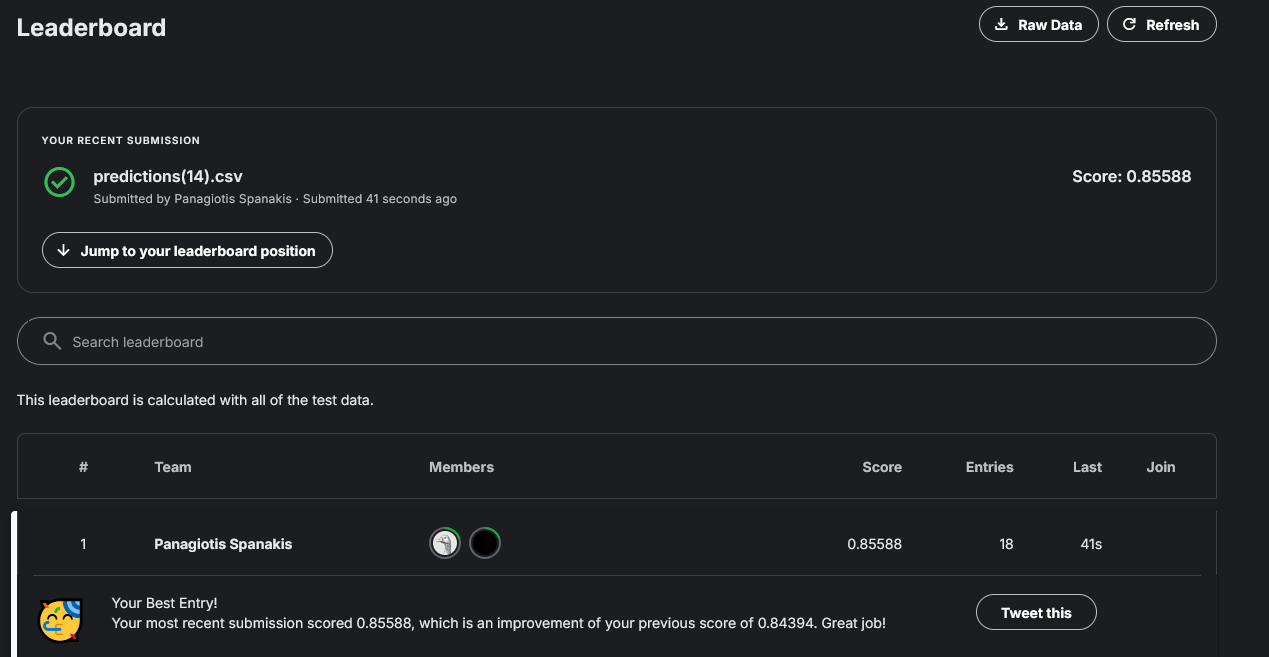

Τέλος, μπορούμε να δούμε και την αρχιτεκτονική του quantized μοντέλου με τις λιγότερες παραμέτρους.

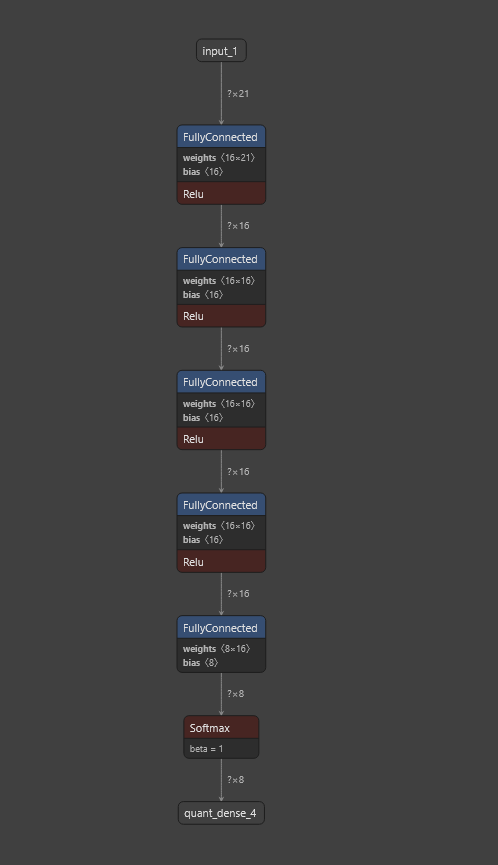